In [1]:
# =============================================================
# DSRN for Drosophila Gene Expression Prediction (with coords)
# Predict next timepoint from previous timepoint; include (x,y,z)
# =============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import seaborn as sns
import os, json

# -----------------------------
# Config / Files
# -----------------------------
file = "valid_genes_filtered.csv"   # ensure this is present
assert os.path.exists(file), f"File not found: {file}"

# reservoir / solver params (tweakable)
t_initial, t_final = 0, 2
num_eval_points = 50

# -----------------------------
# Load table
# -----------------------------
df = pd.read_csv(file, header=None)   # your file had no header
print("Loaded data shape:", df.shape)

# Data layout assumptions (per earlier messages):
# - row 0: name row (NaN in col0, then cell labels)
# - row 1: x_coord
# - row 2: y_coord
# - row 3: z_coord
# - rows 4.. end: gene rows in blocks of 6 (gene_t1, gene_t2, ..., gene_t6)
#   Each such row: [gene_name_t?, val_cell1, val_cell2, ..., val_cellN]
# We'll take columns 1: because column 0 contains gene names/labels.

# -----------------------------
# Extract coords and expressions
# -----------------------------
coords_rows = df.iloc[2:5, 1:].astype(float).values    # shape (3, num_cells) -> x,y,z
expr_rows   = df.iloc[5:, 1:].astype(float).values    # shape (6*num_genes, num_cells)

num_cells = expr_rows.shape[1]
num_gene_rows = expr_rows.shape[0]          # should be 6 * num_genes
assert num_gene_rows % 6 == 0, "Expected gene rows to be multiple of 6"
num_genes = num_gene_rows // 6

print(f"Cells (samples) = {num_cells}, Genes = {num_genes} (6 timepoints each)")

# -----------------------------
# Build X and Y: transitions t->t+1 across genes
# For each gene block (6 rows), we build 5 transitions:
#   X = row t  (values across all cells)  -> shape (num_features, num_cells)
#   Y = row t+1
# Note: We'll later add coords (3 rows) as extra input features.
# -----------------------------
X_list = []
Y_list = []

for g in range(num_genes):
    block = expr_rows[g*6:(g+1)*6, :]   # shape (6, num_cells)
    for t in range(5):                  # transitions: 0->1,1->2,...,4->5
        X_list.append(block[t, :].copy())    # shape (num_cells,)
        Y_list.append(block[t+1, :].copy())

# stack into arrays
X = np.vstack(X_list)   # shape (5*num_genes, num_cells)
Y = np.vstack(Y_list)   # same shape

print("Raw X shape (transitions x cells):", X.shape)
print("Raw Y shape (transitions x cells):", Y.shape)

# -----------------------------
# Add coordinates as additional constant features
# coords_rows shape = (3, num_cells)
# We want to prepend these 3 rows so the input feature dimension increases by 3.
# After this: X_with_coords shape = (5*num_genes + 3, num_cells)
# -----------------------------
X_with_coords = np.vstack([coords_rows, X])   # coords first, then gene-transition rows
print("X_with_coords shape (features x cells):", X_with_coords.shape)

# You may want to scale coords differently (e.g., standardize) — we'll standardize globally below.

# ============ COMPUTE ENTROPY ==============
def compute_topological_entropy(trajectory, eps_values):
    entropy_estimates = {}
    for eps in eps_values:
        unique_orbits = set()
        for point in trajectory:
            rounded_point = tuple(np.round(point / eps))  
            unique_orbits.add(rounded_point)
        N_n_eps = len(unique_orbits)
        entropy_estimates[eps] = np.log(N_n_eps) / len(trajectory)  
    return entropy_estimates

# -----------------------------
# Lorenz / Rossler-like reservoir function (Lorenz here)
# -----------------------------
def lorenz_system(t, Xvec, params, N):
    # Xvec length = 3*N -> reshape to (N, 3)
    X = Xvec.reshape(N, 3)
    sigma = params[:, 0]
    rho   = params[:, 1]
    beta  = params[:, 2]
    T_val = params[:, 3]   # timescale
    dx = (sigma * (X[:, 1] - X[:, 0])) / T_val
    dy = (X[:, 0] * (rho - X[:, 2]) - X[:, 1]) / T_val
    dz = (X[:, 0] * X[:, 1] - beta * X[:, 2]) / T_val
    return np.stack([dx, dy, dz], axis=1).flatten()

seed_list = [46, 2, 10, 100, 80, 20, 60]

for seed in seed_list:

    print(f"======================")
    print(f"Running experiment for seed = {seed}")
    
    np.random.seed(seed)

    # -----------------------------
    # Train/test split across cells (samples)
    # 80% cells train, 20% test — i.e., columns are samples
    # -----------------------------
    cells = np.arange(num_cells)
    train_cells, test_cells = train_test_split(cells, test_size=0.2, random_state=seed)
    print("Train cells:", len(train_cells), "Test cells:", len(test_cells))

    # -----------------------------
    # Normalize (global scalers)
    # We'll fit scalers on all training cells (columns) for inputs & outputs.
    # Our scalers must operate on (samples x features) when using sklearn — so we transpose.
    # - input scaler fits on X_with_coords.T shape (num_cells, num_features)
    # - output scaler fits on Y.T shape (num_cells, num_output_features)
    # After transform we transpose back to keep shape (features, cells)
    # -----------------------------
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    
    # Fit using only train cells to avoid leakage
    scaler_X.fit(X_with_coords[:, train_cells].T)   # shape (n_train_cells, n_features)
    scaler_Y.fit(Y[:, train_cells].T)
    
    X_norm = scaler_X.transform(X_with_coords.T).T   # (features, cells)
    Y_norm = scaler_Y.transform(Y.T).T               # (features, cells)  (features == transitions)
    
    print("X_norm shape:", X_norm.shape, "Y_norm shape:", Y_norm.shape)
    
    # Dimensions used by reservoir code:
    M = X_norm.shape[0]   # input dimension (features) -> now includes 3 coords + 5*num_genes
    D = X_norm.shape[1]   # number of samples (cells)
    P = Y_norm.shape[0]   # output dim (number of transitions = 5*num_genes)
    print("M (input features) =", M, "D (cells) =", D, "P (output dim) =", P)

    # -----------------------------
    # Reservoir setup
    # -----------------------------
    # reservoir_params: for each of N reservoirs: (sigma, rho, beta, T)
    param_range_reservoir = [(9.9, 10.1), (27.9, 28.1), (2.65, 2.70)]
    eps_values = [2.5] # take lower value of epsilon where the topological entropy is already saturated for low no of reservoirs
    
    # N_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300]
    N_values = list(range(10, 301, 10))  # [10, 20, 30, ...]    

    for N in N_values:
        print(f"Running: seed={seed}, N={N}")
    
        # ====== FOLDER ======
        save_dir = f"results_dsrn_drosophila"
        os.makedirs(save_dir, exist_ok=True)
        
        # ====== CSV PATH ======
        results_csv = os.path.join(save_dir, f"results_summary_drosophila_3.csv")
    
        # ====== CREATE CSV IF NOT EXISTS ======
        if not os.path.exists(results_csv):
            df_init = pd.DataFrame(columns=["N", "Train_MSE", "Train_r",
                                            "Test_MSE", "Test_r",
                                            "Avg_Topological_Entropy", "Random seed"])
            df_init.to_csv(results_csv, index=False)
    
        # ====== READ EXISTING ======
        df_existing = pd.read_csv(results_csv)
    
        # ====== CHECK IF (seed, N) EXISTS → SKIP ======
        if ((df_existing["Random seed"] == seed) & (df_existing["N"] == N)).any():
            print(f"Skipping seed={seed}, N={N} (already exists in CSV)")
            continue
    
        reservoir_params = np.array([
            [np.random.uniform(low, high) for (low, high) in param_range_reservoir] + [np.random.uniform(0.5, 2)]
            for _ in range(N)
        ])  # shape (N, 4)
        
        # Input matrix R: shape (3*N, M) to map M-dim input vector into 3N initial conditions
        R = np.random.uniform(-1.0, 1.0, size=(3 * N, M))
    
        # =====================================================
        # RESERVOIR COMPUTATION
        # =====================================================
        # -----------------------------
        # Compute reservoir states φ for each cell (sample)
        # φ has shape (3*N, D)
        # For each cell i: initial cond = R @ X_norm[:, i]   (length 3N)
        # integrate to t_final, take final state sol.y[:,-1]
        # -----------------------------
        phi = np.zeros((3 * N, D))
        entropy_all = []
        
        for i in range(D):
            init = (R @ X_norm[:, i]).flatten()
            t_eval = np.linspace(t_initial, t_final, num_eval_points)
            sol = solve_ivp(lorenz_system, (t_initial, t_final), init, t_eval=t_eval,
                            args=(reservoir_params, N), rtol=1e-6, atol=1e-9)
            phi[:, i] = sol.y[:, -1]
            trajectory = sol.y.T
            trajectory = (trajectory - trajectory.mean(axis=0)) / np.maximum(trajectory.std(axis=0), 1e-12)
            entropy_values = compute_topological_entropy(trajectory, eps_values)
            entropy_all.append(np.mean(list(entropy_values.values())))
    
        mean_entropy = np.mean(entropy_all)
    
        # -----------------------------
        # Prepare training matrices for readout learning
        # Note: we use only train_cells columns for training
        # phi_train: (n_train_samples, features) for lstsq we need as (samples, features)
        # Y_train:    (n_train_samples, P_out) float
        # -----------------------------
        phi_train = phi[:, train_cells].T    # shape (n_train, 3N)
        phi_test  = phi[:, test_cells].T     # shape (n_test , 3N)
        
        Y_train = Y_norm[:, train_cells].T   # shape (n_train, P)
        Y_test  = Y_norm[:, test_cells].T    # shape (n_test, P)
    
        # -----------------------------
        # Solve for S (readout) with least squares (no ridge)
        # We solve phi_train @ S_T = Y_train  -> S_T = np.linalg.lstsq(phi_train, Y_train)
        # S_T shape (3N, P), so S = S_T.T will be (P, 3N)
        # -----------------------------
        S_T, residuals, rank, svals = np.linalg.lstsq(phi_train, Y_train, rcond=None)
        S = S_T.T
    
        # -----------------------------
        # Predict (on normalized scale)
        # pred_norm = S @ phi[:, idx]  -> gives shape (P, n_cells)
        # -----------------------------
        pred_train_norm = S @ phi[:, train_cells]   # (P, n_train)
        pred_test_norm  = S @ phi[:, test_cells]    # (P, n_test)
        
        # inverse-transform predictions to original output scale using scaler_Y
        # scaler_Y expects shape (n_samples, n_features) = (n_train, P) so transpose
        pred_train = scaler_Y.inverse_transform(pred_train_norm.T).T   # (P, n_train)
        pred_test  = scaler_Y.inverse_transform(pred_test_norm.T).T    # (P, n_test)
        
        # Ground-truth (original Y)
        Y_train_true = Y[:, train_cells].astype(float)   # (P, n_train)
        Y_test_true  = Y[:, test_cells].astype(float)    # (P, n_test)
        
        # Ensure float arrays
        pred_train = pred_train.astype(float)
        pred_test  = pred_test.astype(float)
        
        # -----------------------------
        # Metrics
        # -----------------------------
        mse_train = np.mean((pred_train - Y_train_true) ** 2)
        mse_test  = np.mean((pred_test  - Y_test_true) ** 2)
        r_train, p_train = pearsonr(pred_train.flatten(), Y_train_true.flatten())
        r_test,  p_test  = pearsonr(pred_test.flatten(),  Y_test_true.flatten())
    
        # ====== FOLDER ======
        save_dir = f"results_dsrn_drosophila"
        os.makedirs(save_dir, exist_ok=True)
        
        # ====== CSV PATH ======
        results_csv = os.path.join(save_dir, f"results_summary_drosophila_3.csv")
        
        # ====== PREPARE METRICS DICTIONARY ======
        results_dict = {
            "N": N,
            "Train_MSE": mse_train,
            "Train_r": r_train,
            "Test_MSE": mse_test,
            "Test_r": r_test,
            "Avg_Topological_Entropy": mean_entropy,  
            "Random seed": seed,
        }
        
        # ====== CREATE CSV IF NOT EXISTS ======
        if not os.path.exists(results_csv):
            df_init = pd.DataFrame(columns=list(results_dict.keys()))
            df_init.to_csv(results_csv, index=False)
        
        # ====== READ EXISTING CSV ======
        df_existing = pd.read_csv(results_csv)
    
        # Append new row
        df_result = pd.DataFrame([results_dict])
        df_combined = pd.concat([df_existing, df_result], ignore_index=True)
        df_combined.to_csv(results_csv, index=False)
        print(f" Results for N={N} saved/updated in CSV")


/tmp/ipykernel_3714349/4290327223.py:29: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,

Loaded data shape: (167, 6079)
Cells (samples) = 6078, Genes = 27 (6 timepoints each)
Raw X shape (transitions x cells): (135, 6078)
Raw Y shape (transitions x cells): (135, 6078)
X_with_coords shape (features x cells): (138, 6078)
Running experiment for seed = 46
Train cells: 4862 Test cells: 1216
X_norm shape: (138, 6078) Y_norm shape: (135, 6078)
M (input features) = 138 D (cells) = 6078 P (output dim) = 135
Running: seed=46, N=10
Skipping seed=46, N=10 (already exists in CSV)
Running: seed=46, N=20
Skipping seed=46, N=20 (already exists in CSV)
Running: seed=46, N=30
Skipping seed=46, N=30 (already exists in CSV)
Running: seed=46, N=40
Skipping seed=46, N=40 (already exists in CSV)
Running: seed=46, N=50
Skipping seed=46, N=50 (already exists in CSV)
Running: seed=46, N=60
Skipping seed=46, N=60 (already exists in CSV)
Running: seed=46, N=70
Skipping seed=46, N=70 (already exists in CSV)
Running: seed=46, N=80
Skipping seed=46, N=80 (already exists in CSV)
Running: seed=46, N=90
Sk

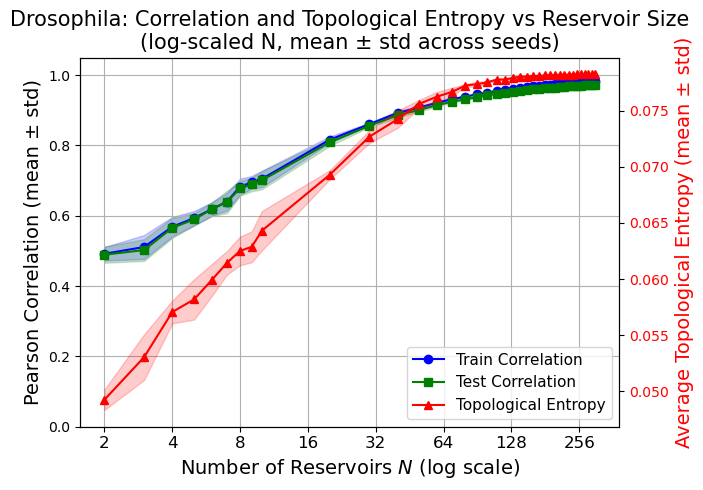

In [2]:
# ====== Load saved results CSV ======
results_csv = "results_dsrn_drosophila/results_summary_drosophila_3.csv"
df = pd.read_csv(results_csv)

# ====== Group by N across seeds ======
grouped = df.groupby("N")

# Sort N explicitly
N_values = np.array(sorted(grouped.groups.keys()))
logN = np.log(N_values)

# Mean values
train_corr_mean = grouped["Train_r"].mean().loc[N_values].values
test_corr_mean  = grouped["Test_r"].mean().loc[N_values].values
entropy_mean    = grouped["Avg_Topological_Entropy"].mean().loc[N_values].values

# Std values (replace NaN with 0 if single seed)
train_corr_std = grouped["Train_r"].std().loc[N_values].fillna(0).values
test_corr_std  = grouped["Test_r"].std().loc[N_values].fillna(0).values
entropy_std    = grouped["Avg_Topological_Entropy"].std().loc[N_values].fillna(0).values


# ====== Plot ======
fig, ax1 = plt.subplots(figsize=(7, 5))

# ---- Left Y-axis: correlation ----
ax1.set_xlabel(r"Number of Reservoirs $N$ (log scale)", fontsize=14)
ax1.set_ylabel("Pearson Correlation (mean ± std)", fontsize=14)

# Train correlation (BLUE)
ax1.plot(logN, train_corr_mean, '-o', color='blue', label='Train Correlation')
ax1.fill_between(
    logN,
    train_corr_mean - train_corr_std,
    train_corr_mean + train_corr_std,
    color='blue',
    alpha=0.2
)

# Test correlation (GREEN)
ax1.plot(logN, test_corr_mean, '-s', color='green', label='Test Correlation')
ax1.fill_between(
    logN,
    test_corr_mean - test_corr_std,
    test_corr_mean + test_corr_std,
    color='green',
    alpha=0.2
)

ax1.set_ylim(0, 1.05)
ax1.grid(True)

# ---- Right Y-axis: entropy ----
ax2 = ax1.twinx()
ax2.set_ylabel("Average Topological Entropy (mean ± std)", color='red', fontsize=14)

ax2.plot(logN, entropy_mean, '-^', color='red', label='Topological Entropy')
ax2.fill_between(
    logN,
    entropy_mean - entropy_std,
    entropy_mean + entropy_std,
    color='red',
    alpha=0.2
)

ax2.tick_params(axis='y', labelcolor='red')


# ====== Sparse, readable x-ticks ======
# Option 1: powers of 2 (best for scaling)
tick_N = np.array([2, 4, 8, 16, 32, 64, 128, 256])
tick_N = tick_N[tick_N <= N_values.max()]
tick_logN = np.log(tick_N)

ax1.set_xticks(tick_logN)
ax1.set_xticklabels(tick_N, fontsize=12)


# ---- Combined Legend ----
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='lower right',
    fontsize=11
)

plt.title(
    "Drosophila: Correlation and Topological Entropy vs Reservoir Size\n"
    "(log-scaled N, mean ± std across seeds)",
    fontsize=15
)

plt.tight_layout()
plt.savefig(
    "drosophila_corr_vs_topo_mean_std.jpeg",
    format='jpeg',
    dpi=650,
    bbox_inches="tight"
)
plt.show()
